# SMOOTH SPECTRA:
- smooth spectra
- remove galaxy emission lines (except Halpha in IIn)
- remove telluric/ sky emission lines if not already done 

In [15]:
import os
#COCO_PATH=os.environ['COCO_PATH']
COCO_PATH="/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates/"
DATASPEC_PATH = COCO_PATH+"/Inputs/Spectroscopy/"
DATAINFO_PATH= COCO_PATH+"Inputs/SNe_Info/"
FILTER_PATH = COCO_PATH+"Inputs/Filters/"
#

In [2]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import pandas as pd
from astropy.io import fits
import astropy.units as u
import matplotlib.cm as cm
import scipy.signal as ss
from scipy.stats import norm

%matplotlib inline

#### important spectral lines

In [3]:
Halpha = 6564.614 * u.Angstrom
Hbeta = 4862.721 * u.Angstrom
Hgamma = 4341.68 * u.Angstrom

Fe = 4250.78
S_II_1 = 6718.29 * u.Angstrom
S_II_2 = 6732.68 * u.Angstrom
O_III_1 = 4960.295 * u.Angstrom
O_III_2 = 5008.239 * u.Angstrom
O_I_1 = 6302.046 * u.Angstrom
O_I_2 = 6365.536 * u.Angstrom

#Sky lines
O2_1 = 7605 * u.Angstrom
O2_2 = 6869 * u.Angstrom
O2_3 = 6562 * u.Angstrom

boh_2 = 4250 * u.Angstrom
boh_3 = 5300 * u.Angstrom



In [4]:
lines = np.array([Halpha.value, Hbeta.value, Hgamma.value, 
         S_II_1.value, S_II_2.value, O_III_1.value, 
         O_III_2.value, O_I_1.value, O_I_2.value,
        O2_1.value, O2_2.value, O2_3.value, boh_2.value, boh_3.value])

info_file = pd.read_csv(DATAINFO_PATH+'info.dat', comment='#', delimiter=' ')

In [5]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
   """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    order_range_deriv = range(order)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    b_deriv = np.mat([[(i+1)*k**(i) for i in order_range_deriv] for k in range(-half_window, half_window+1)])

    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    m_deriv = np.linalg.pinv(b_deriv).A[deriv] * rate**deriv * factorial(deriv)

    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = np.median(y[:half_window]) - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = np.median(y[-half_window:]) + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    firstvals = 2*y[0] - y[1:half_window+1][::-1]
    lastvals = 2*y[-1] - y[-half_window-1:-1][::-1]
    y_ext = np.concatenate((firstvals, y, lastvals))

    fl_smooth = np.convolve( m[::-1], y_ext, mode='valid')
    fl_smooth_ext = np.concatenate((firstvals, fl_smooth, lastvals))
    fl_smooth_err = (np.convolve( m_deriv[::-1], (y_ext - fl_smooth_ext)**2, mode='valid'))**0.5
    print ('some nans in flux!!!', len(fl_smooth[np.isnan(fl_smooth)]), len(fl_smooth))

    print ('some nans!', len(fl_smooth_err[np.isnan(fl_smooth_err)]), len(fl_smooth_err))
    print ('MIN!', np.min(fl_smooth_err[~np.isnan(fl_smooth_err)]))

    fl_smooth_err[np.isnan(fl_smooth_err)] = np.min(fl_smooth_err[~np.isnan(fl_smooth_err)])
    print ('some nans!', len(fl_smooth_err[np.isnan(fl_smooth_err)]), len(fl_smooth_err))

    
    return fl_smooth, fl_smooth_err


In [6]:
def savitzky_golay_uncert(y, window_size):
    import numpy as np
    from math import factorial

    order = 2
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError as msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    order_range_deriv = range(order)
    half_window = (window_size -1) // 2
    
    return None



In [7]:
    def remove_emission_lines(self):
        for l in lines*(1.+self.redshift):
            mask_line = (self.wls>l-2.)&(self.wls<l+2.)
            linear_interp = np.interp(self.wls[mask_line], 
                                      [self.wls[mask_line][0],self.wls[mask_line][-1]],
                                     [self.flux_UNsmooth[mask_line][0],self.flux_UNsmooth[mask_line][-1]])
            self.flux_UNsmooth[mask_line] = linear_interp
        return None

In [8]:
class Spectra_xTarget():
    """Class with photometry for each object:
            - load the photometry from the DATA folder
            - get the phootmetry in each filter
            - plot the raw photometry 
            - fit the photometry using GP
    """
    
    def __init__(self, snname, verbose=False):
        """
        """
        ## Initialise the class variables
        self.spec_data_path = DATASPEC_PATH+'/1_spec_original/'
        self.spec_list_path = DATASPEC_PATH+'/1_spec_lists_original/'
        self.spec_smooth_data_path = DATASPEC_PATH+'/2_spec_smoothed/'
        self.spec_smooth_list_path = DATASPEC_PATH+'/2_spec_lists_smoothed/'

        self.snname = snname   
        
        mask_tgt = info_file['Name']==self.snname 
        self.sninfo = info_file[mask_tgt]
        if len(info_file[mask_tgt])==0:
            raise Exception((' !!!!!!!!!!!!! \n I CANT FIND THIS OBJECT IN THE info.dat FILE!! \n Add it to the PYCOCO/info/info.dat first.'))
        self.redshift = self.sninfo['z'].values[0]
        self.sn_type = self.sninfo['Type'].values[0]

        self.create_results_folder()
        
    def get_spec_list(self, verbose=False):
        phase_list_file = self.spec_list_path + self.snname+'.list'
        try: 
            parse_phase = np.genfromtxt(phase_list_file, dtype=None, encoding=None)
            specs_list = (np.array([f.split('/')[-1] for f in parse_phase['f0']]))
            mjds_list = (parse_phase['f2'])
            parse_phase_unique = np.unique(parse_phase)
            print (len(specs_list), len(mjds_list), len(parse_phase_unique))
            unique_list, unique_index = np.unique(specs_list, return_index=True)
            self.specs_list = specs_list#unique_list
            self.mjds_list = mjds_list#[unique_index]
            return specs_list
        except IOError: 
            raise Exception('I looked into %s and I found NO spectra? Ooops'%phase_list_file)
            return np.array([])
    
    def smooth_all(self, d_wls):
        list_sorted = self.get_spec_list()[np.argsort(self.mjds_list)]
        mjds_sorted = np.sort(self.mjds_list)
        min_mjd = min(mjds_sorted)
        fout_list = open(self.spec_smooth_list_path+ self.snname+'.list', 'w')
        print (mjds_sorted-min_mjd, min_mjd)
        
        for mjd,sp_file in zip(mjds_sorted, list_sorted):
            if mjd-min_mjd>400:
                pass
            else:
                final_file = self.smooth_single(sp_file, d_wls)
                fout_list.write('%.6f\t%.6f\t%s\n'%(mjd, mjd-min_mjd, final_file))
        fout_list.close()
        return None

    def load_spectrum(self, sp_file_name):
        sp = np.genfromtxt(self.spec_data_path+'/%s/%s'%(self.snname, sp_file_name), 
                           dtype=float, usecols = [0,1], names=['wls', 'flux'], comments='#', 
                           missing_values='NaN')
        
        #self.flux_UNsmooth = sp['flux'][(~np.isnan(sp['wls']))&(sp['flux']>10**-35)&(sp['wls']<10500.)]
        #elf.wls = sp['wls'][(~np.isnan(sp['wls']))&(sp['flux']>10**-35)&(sp['wls']<10500.)]
        self.flux_UNsmooth = sp['flux'][(~np.isnan(sp['wls'])) & (sp['flux'] > 10**-35)]
        self.wls = sp['wls'][(~np.isnan(sp['wls'])) & (sp['flux'] > 10**-35)]
        
        
    def smooth_single(self, sp_file_name, d_wls):
        
        self.load_spectrum(sp_file_name)
        #self.remove_glitches_lines()
        #self.remove_emission_lines()
        x_min, x_max = np.min(self.wls)-500, np.max(self.wls)+500
        fig = plt.figure(figsize=(10,5))
        plt.subplot(311)
        self.clipping(sp_file_name)
        plt.hlines(0, 3000,9000, linestyle=':', color='r')
        plt.xlim(x_min, x_max)
        D_wls = float(max(self.wls)- min(self.wls))
        window_lenght =  (round(d_wls/(D_wls/len(self.wls)),0))
        
        if window_lenght % 2 ==0.:
            window_lenght=window_lenght+1.
        
        #flux_smooth_err = savitzky_golay(self.flux_clipped, int(window_lenght) ,5)
        
        flux_smooth = ss.savgol_filter(self.flux_clipped, int(window_lenght) ,5, mode='nearest')
        #flux_smooth_err = np.zeros(len(flux_smooth))

        self.flux_smooth = flux_smooth#[flux_smooth>0.]
        #self.flux_smooth_err = flux_smooth_err#[flux_smooth>0.]
        self.wls_smooth = self.wls#[flux_smooth>0.]
        
        #if self.sn_type == 'IIn':
        #    # keep Halpha:
        #    H_alpha_sn = Halpha.value*(1.+self.redshift)
        #    mask_Halpha_window = ( self.wls_smooth>H_alpha_sn-100.)&( self.wls_smooth<H_alpha_sn+100.)
        #    self.flux_smooth[mask_Halpha_window] = np.copy(self.flux_clipped[mask_Halpha_window])
            
        self.residuals = self.flux_clipped-self.flux_smooth
        df = pd.DataFrame(self.wls_smooth, columns=['w'])
        df['residuals'] = self.residuals
        window_wls = 50.
        window = int((len(df.w)*window_wls)/(max(df.w)-min(df.w)))
        
        flux_smooth_err = df['residuals'].rolling(window=window, center=True).std()
        self.flux_smooth_err = flux_smooth_err#[flux_smooth>0.]

        self.flux_smooth_err.ffill(inplace=True)
        self.flux_smooth_err.bfill(inplace=True)

        self.SNR = self.flux_smooth/self.flux_smooth_err 
        
        # save plot
        plt.subplot(312)
        plt.plot(self.wls, self.flux_clipped, 'k', lw=0.8, label='Clipped spectrum')
        plt.fill_between(self.wls_smooth, self.flux_smooth-self.flux_smooth_err, 
                 self.flux_smooth+self.flux_smooth_err, facecolor='r', alpha=0.5)
        plt.hlines(0, 3000,9000, linestyle=':', color='r')
        plt.xlim(x_min, x_max)
        #plt.xlim(1700., 10100.)
        #plt.xlim(1700., 25000)

        SNR_threshold =3.        
        #plt.plot(self.wls_smooth[mask_snr], self.flux_smooth[mask_snr],'.m', lw=4.)
        #
        #[CHANGE]: i'm commenting out these next 2 blocks to try plotting the total SNR and not cut it off anywhere
        '''SNR_blue = np.copy(self.SNR[self.wls_smooth<4000.])
        wls_blue = np.copy(self.wls_smooth[self.wls_smooth<4000.])
        if np.any(SNR_blue<SNR_threshold):
            max_wls = max(wls_blue[SNR_blue<SNR_threshold])
            print ('max_wls',max_wls)
            self.chopp_wls_min = max_wls
            self.wls_smooth[self.wls_smooth<max_wls] = np.nan
            self.flux_smooth[self.wls_smooth<max_wls] = np.nan
            self.flux_smooth_err[self.wls_smooth<max_wls] = np.nan
        else:
            self.chopp_wls_min = np.nan

        SNR_red = np.copy(self.SNR[self.wls_smooth>8500.])
        wls_red = np.copy(self.wls_smooth[self.wls_smooth>8500.])
        if np.any(SNR_red<SNR_threshold):
            #min_wls = min(wls_red[SNR_red<10.])
            min_wls = min(wls_red[SNR_red<3.])
            print ('min_wls', min_wls)
            self.chopp_wls_max = min_wls
            self.wls_smooth[self.wls_smooth>min_wls] = np.nan
            self.flux_smooth[self.wls_smooth>min_wls] = np.nan
            self.flux_smooth_err[self.wls_smooth>min_wls] = np.nan
        else:
            self.chopp_wls_max = np.nan'''

        #[CHANGE]: this is the previous plotting for the 2nd plot, i'm changing and trying something else
        #plt.plot(self.wls_smooth, self.flux_smooth, 'or', ms=2, label='Savitsky-Golay smoothing')
        #plt.plot(self.wls_smooth[self.flux_smooth<0.], self.flux_smooth[self.flux_smooth<0.], '.m', ms=2)
        plt.plot(self.wls_smooth, self.flux_smooth, 'or', ms=2, label='Savitzky-Golay smoothing')

        #plt.vlines(lines*(1.+self.redshift),
                   #min(self.flux_smooth), max(self.flux_smooth), 
                   #color='m', linestyle='-', lw=0.5, label='SN frame galaxy/telluric lines')
        #plt.vlines([self.chopp_wls_min, self.chopp_wls_max],

        #[CHANGE]: took out this line because it was the SNR of 3 limit, can add back later
                   #min(self.flux_smooth), max(self.flux_smooth), 
                   #color='g', linestyle='-', lw=3.5, label='CHOP S/N below %.1f'%SNR_threshold)

        plt.legend(fontsize=7)
        plt.subplot(313)
        #plt.plot(self.wls_smooth, self.flux_clipped-self.flux_smooth,'-k', label='Residuals')
        #plt.fill_between(self.wls_smooth, self.flux_smooth_err.values, 
        #                 -self.flux_smooth_err.values, facecolor='r', alpha=0.5, label='Rsiduals rolling std')
        plt.plot(self.wls_smooth, self.SNR,'-k', label='S/N')
        plt.hlines(3, 3000,10300, linestyle=':', color='r')
        plt.yscale('log')
        #[CHANGE]: took out this line because SNR 3 limit, can add back later
        #plt.vlines([self.chopp_wls_min, self.chopp_wls_max], 0.7, 20,
                   #color='g', lw=3, label='CHOP S/N below %.1f'%SNR_threshold)
        plt.xlim(x_min, x_max)
        #plt.xlim(1700., 10100.)
        #plt.xlim(1700., 25000.)
        plt.subplots_adjust(wspace=0, hspace=0)
        file_ext = sp_file_name.split('.')[-1]
        plt.xlabel('Wavelength')
        plt.ylabel('S to N')
        plt.legend(loc='best', fontsize=7)
        fig.savefig(self.results_mainpath+sp_file_name.replace(file_ext,'png'),#.replace('cal','png').replace('dat','png').replace('ascii','png').replace('flm','png').replace('cal_galsub','png'),
                   bbox_inches='tight')
        plt.show()
        plt.close(fig)

        # save file
        #[CHANGE]: need to change this!! don't want to limit what is written out
        fout = open(self.results_mainpath+sp_file_name, 'w')
        fout.write('#wls\tflux\tflux_err\n')
        for w,f,ferr in zip(self.wls_smooth,self.flux_smooth,self.flux_smooth_err):
            if w<10100: fout.write('%.4f\t%.4e\t%.4e\n'%(w, f,ferr))
        fout.close()

        return self.results_mainpath+sp_file_name 

    def clipping(self, sp_file_name):
        
        self.load_spectrum(sp_file_name)
        x = self.wls
        y = self.flux_UNsmooth
        #fig = plt.figure(figsize=(15,3))
        plt.plot(x, y, label='Raw spectrum')

        df = pd.DataFrame(x, columns=['w'])
        df['fl'] = y
        
        window_wls = 70.
        window = int((len(x)*window_wls)/(max(x)-min(x)))
        
        roll_median = df['fl'].rolling(window=window, center=True).median()
        roll_std = df['fl'].rolling(window=window, center=True).std()
        df['roll_median'] = roll_median
        df['roll_std'] = roll_std
        mask_clip = (np.abs(y-df.roll_median.values)>=3*df.roll_std.values)

        plt.plot(df.w, df.roll_median, 'g', label='Initial rolling median/std')
        plt.fill_between(df.w, df.roll_median-df.roll_std,
                         df.roll_median+df.roll_std, alpha=0.5, facecolor='g')

        it = 0
        while np.any(mask_clip)&(it<100):
            reject_index = np.concatenate([df.index.values[mask_clip]+shift for shift in np.arange(-5,5,1)]) 
            
            df.drop(labels = np.unique(reject_index), axis=0, inplace=True)
            #df.drop(labels = df.index.values[mask_clip]-1, axis=0, inplace=True)
            #df.drop(labels = df.index.values[mask_clip]+1, axis=0, inplace=True)
            
            fl_clipped = np.interp(x, df.w, df.fl)
            df = pd.DataFrame(x, columns=['w'])
            df['fl'] = fl_clipped
            roll_median = df['fl'].rolling(window=40, center=True).median()
            roll_std = df['fl'].rolling(window=40, center=True).std()
            
            if self.sn_type == 'IIn':
                # keep Halpha:
                H_alpha_sn = Halpha.value*(1+self.redshift)
                mask_Halpha_window = (df.w.values>H_alpha_sn-100)&(df.w.values<H_alpha_sn+100)
                roll_median_Halpha = df['fl'][mask_Halpha_window].rolling(window=2, center=True).median()
                roll_std_Halpha = df['fl'][mask_Halpha_window].rolling(window=2, center=True).std()
                roll_median[mask_Halpha_window] = roll_median_Halpha
                roll_std[mask_Halpha_window] = roll_std_Halpha
            df['roll_median'] = roll_median
            df['roll_std'] = roll_std
            mask_clip = (np.abs(fl_clipped-df.roll_median.values)>=3*df.roll_std.values)
            it = it+1
        else:
            fl_clipped = df.fl
        df['flux_UNsmooth'] = self.flux_UNsmooth
        
        plt.plot(df.w, df.roll_median, 'r', label='Rolling median/std of clipped spectrum')
        plt.fill_between(df.w, df.roll_median-df.roll_std,
                         df.roll_median+df.roll_std, alpha=0.5, facecolor='r')

        plt.plot(x, fl_clipped, 'k', label='3 sigma Clipped spectrum')
        plt.legend(loc='best', fontsize=7)
        plt.title(self.snname+'__'+sp_file_name)

        self.flux_clipped = fl_clipped

    def create_results_folder(self):
        results_directory = self.spec_smooth_data_path+'/%s/'%self.snname
        if not os.path.exists(results_directory):
            os.makedirs(results_directory)
        self.results_mainpath = results_directory

    def remove_emission_lines(self):
        #print ('removing lines')
        for l in lines*(1.+self.redshift):
            mask_line = (self.wls>l-10.)&(self.wls<l+10.)
            #print (l, self.wls[mask_line], self.flux_UNsmooth[mask_line])
            if len(self.wls[mask_line])==0:
                pass
            else:
                linear_interp = np.interp(self.wls[mask_line], 
                                      [self.wls[mask_line][0],self.wls[mask_line][-1]],
                                     [self.flux_UNsmooth[mask_line][0],self.flux_UNsmooth[mask_line][-1]])
                self.flux_UNsmooth[mask_line] = linear_interp
                #print (l, self.wls[mask_line], self.flux_UNsmooth[mask_line])
        return None
    
    def remove_glitches_lines(self):
        #print ('removing lines')
        glithces = self.wls[np.abs(self.flux_UNsmooth)<10**-35]
        print(glithces)
        for l in glithces:
            mask_line = (self.wls>l-2.)&(self.wls<l+2.)
            #print (l, self.wls[mask_line], self.flux_UNsmooth[mask_line])
            if len(self.wls[mask_line])==0:
                pass
            else:
                linear_interp = np.interp(self.wls[mask_line], 
                                      [self.wls[mask_line][0],self.wls[mask_line][-1]],
                                     [self.flux_UNsmooth[mask_line][0],self.flux_UNsmooth[mask_line][-1]])
                self.flux_UNsmooth[mask_line] = linear_interp
                #print (l, self.wls[mask_line], self.flux_UNsmooth[mask_line])
        return None

## Trying with KN

In [10]:
spec_class = Spectra_xTarget(snname='AT2017gfo', verbose=True)

In [11]:
spec_list = spec_class.get_spec_list()

19 19 19


In [12]:
a=0
for m,i in zip(spec_class.get_spec_list(), spec_class.mjds_list):
    print(a,i,m)
    a=a+1

19 19 19
0 57983.969002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57983.969002_Phase+1.43d.dat
1 57984.969002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57984.969002_Phase+2.42d.dat
2 57985.974002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57985.974002_Phase+3.41d.dat
3 57986.974002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57986.974002_Phase+4.40d.dat
4 57987.980002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57987.980002_Phase+5.40d.dat
5 57988.990002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57988.990002_Phase+6.40d.dat
6 57990.000002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57990.000002_Phase+7.40d.dat
7 57992.000002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57992.000002_Phase+9.40d.dat
8 57993.000002 UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57993.000002_Phase+10.40d.dat
9 57983.969003 VIS_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57983.969003_Phase+1.43d.dat
10 57984.969003 VIS_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57984.969003_Phase+2.42d.dat
11 57985.974003 VIS_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57985.974

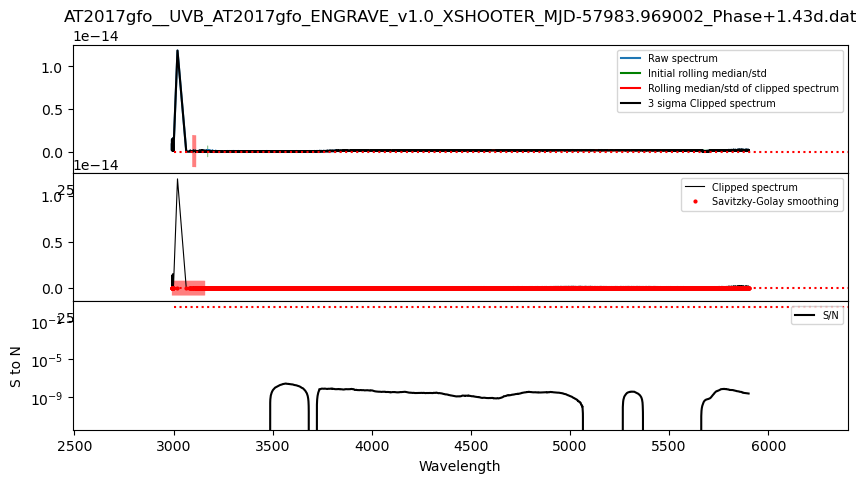

'/Users/ravkaur/Desktop/research/kilonova-SED/PyCoCo_templates//Inputs/Spectroscopy//2_spec_smoothed//AT2017gfo/UVB_AT2017gfo_ENGRAVE_v1.0_XSHOOTER_MJD-57983.969002_Phase+1.43d.dat'

In [13]:
spec_class.smooth_single(spec_list[0], 1000)

19 19 19
[0.00000000e+00 1.00000034e-06 1.00000000e+00 1.00000100e+00
 2.00500000e+00 2.00500100e+00 3.00500000e+00 3.00500100e+00
 4.01100000e+00 4.01100100e+00 5.02100000e+00 5.02100100e+00
 6.03100000e+00 6.03100100e+00 7.03100100e+00 8.03100000e+00
 8.03100100e+00 9.03100000e+00 9.03100100e+00] 57983.969002


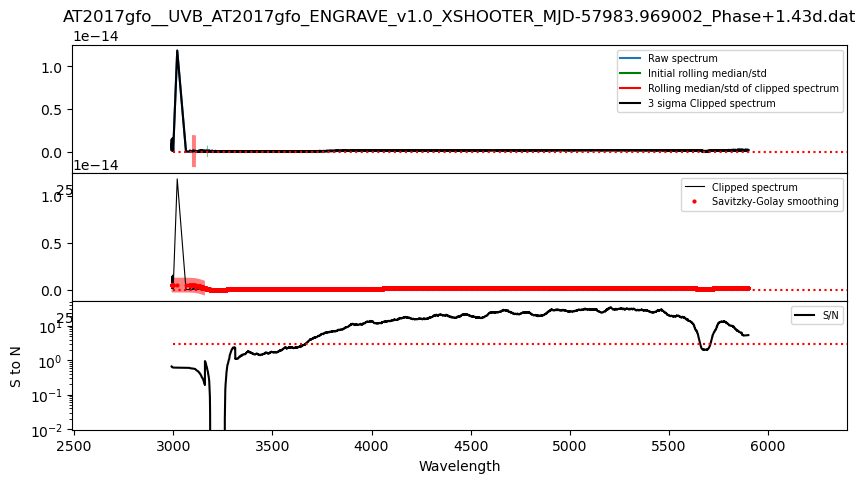

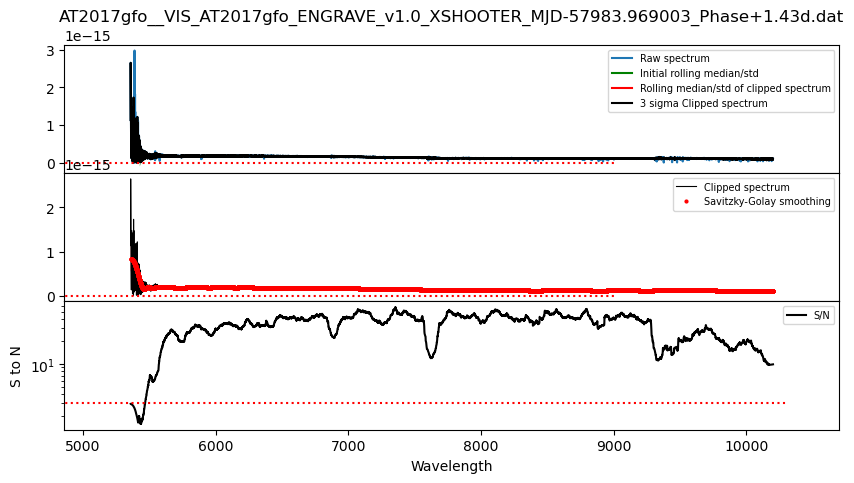

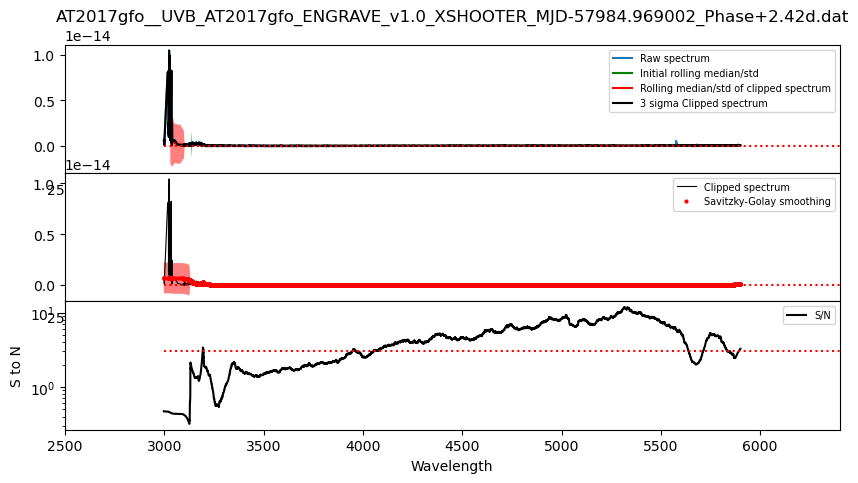

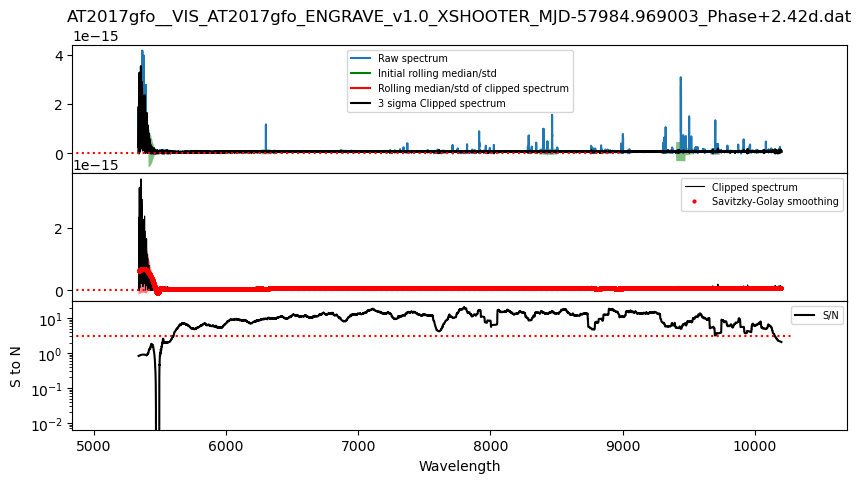

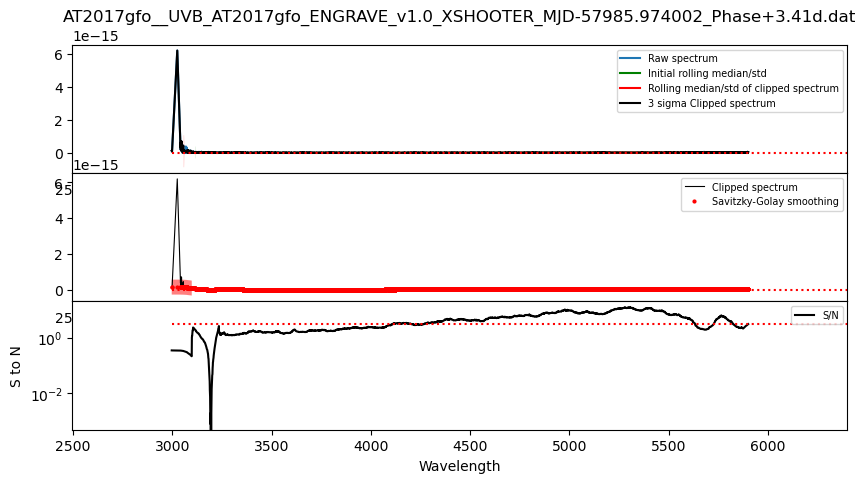

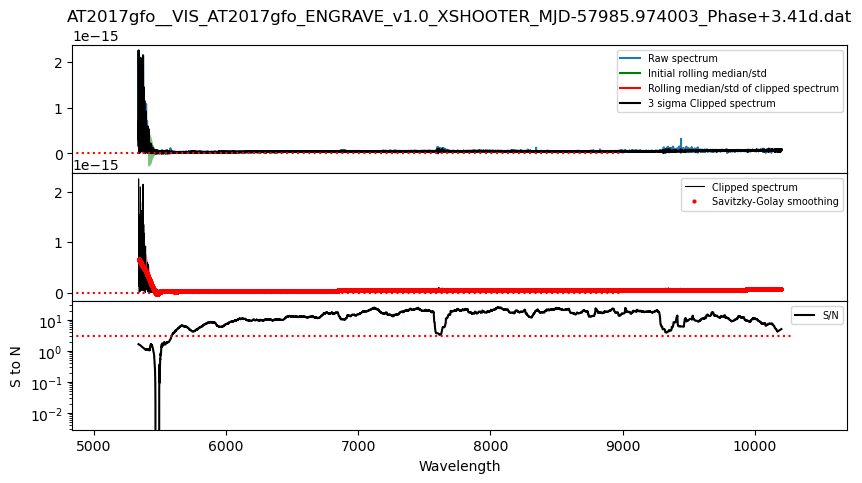

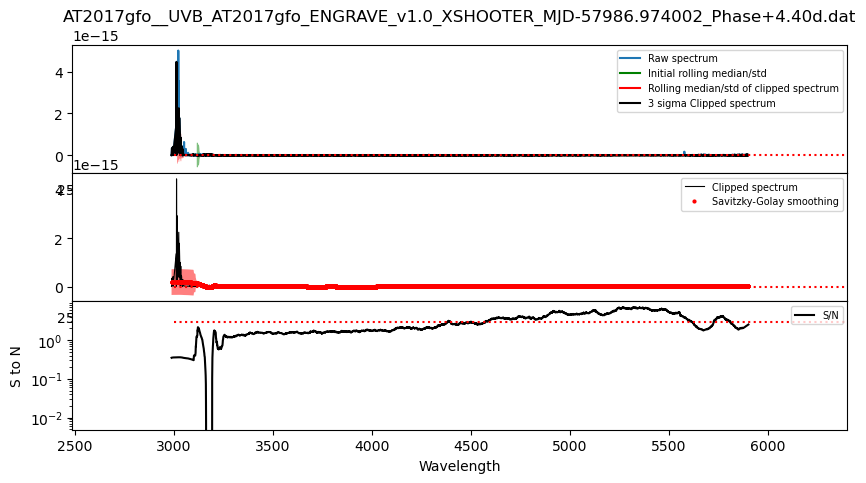

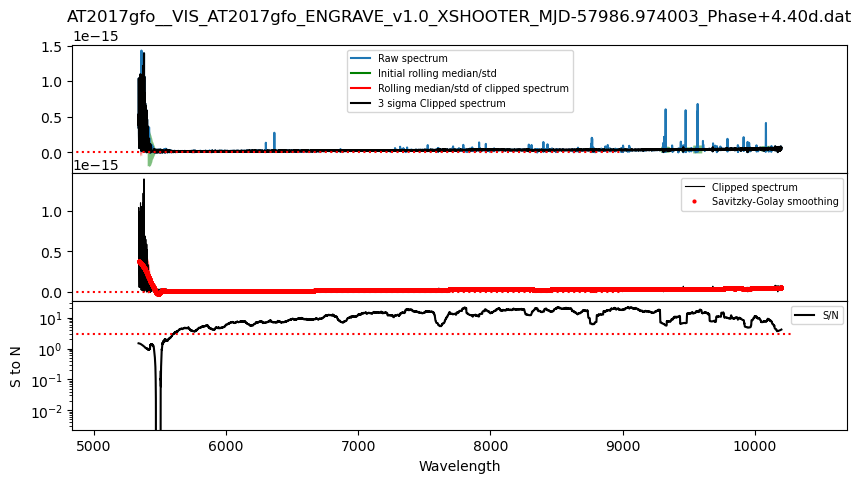

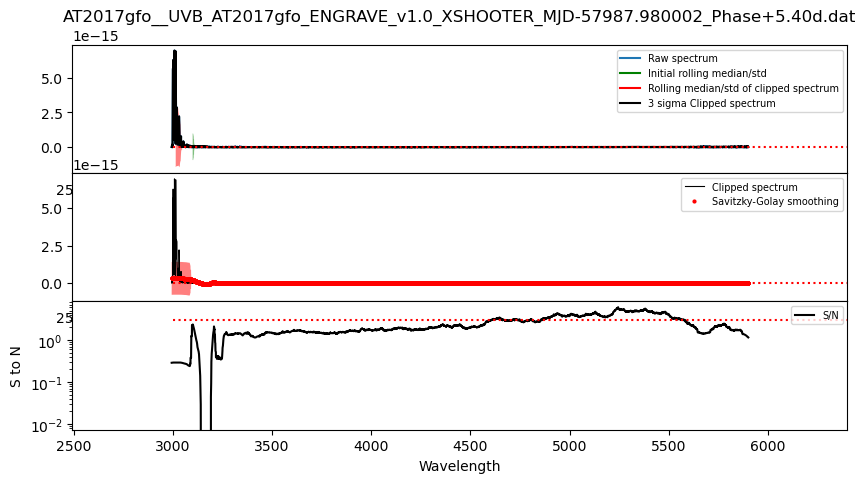

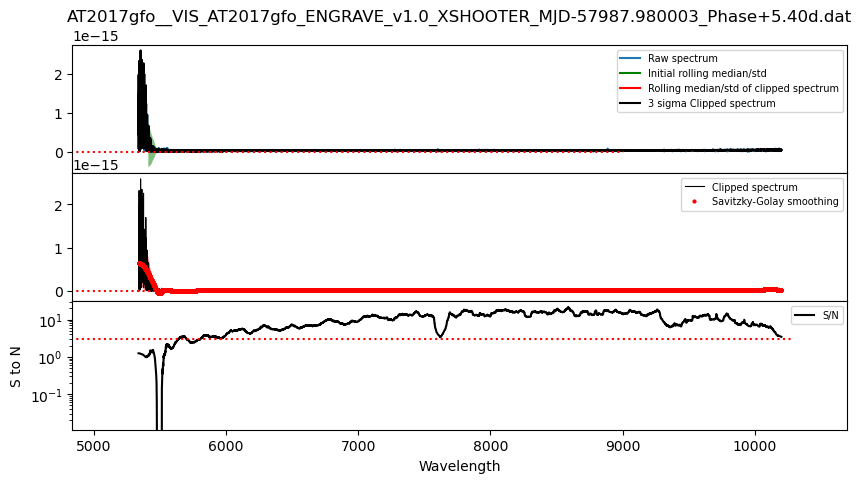

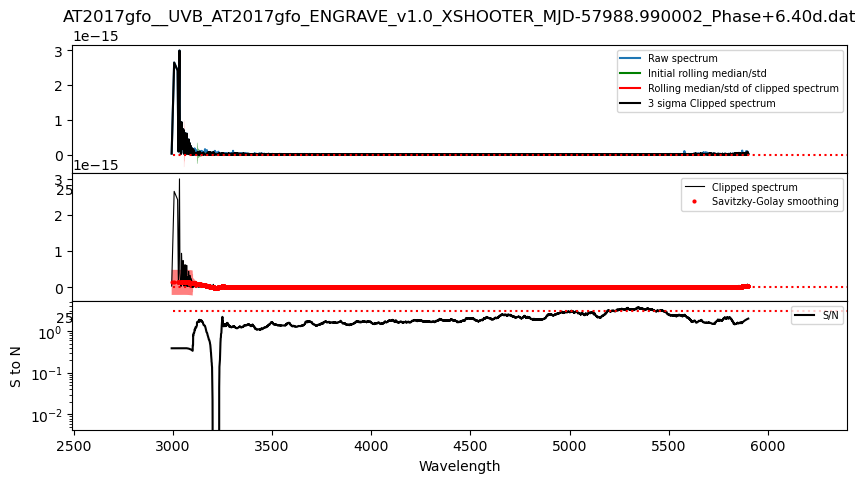

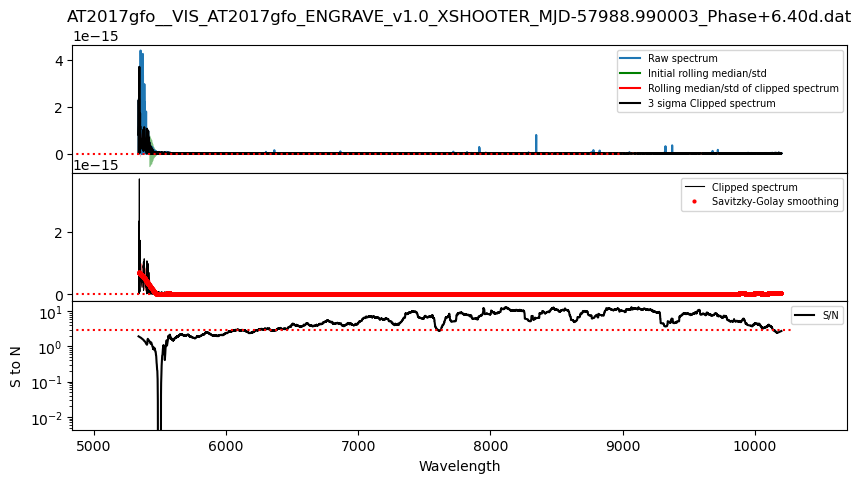

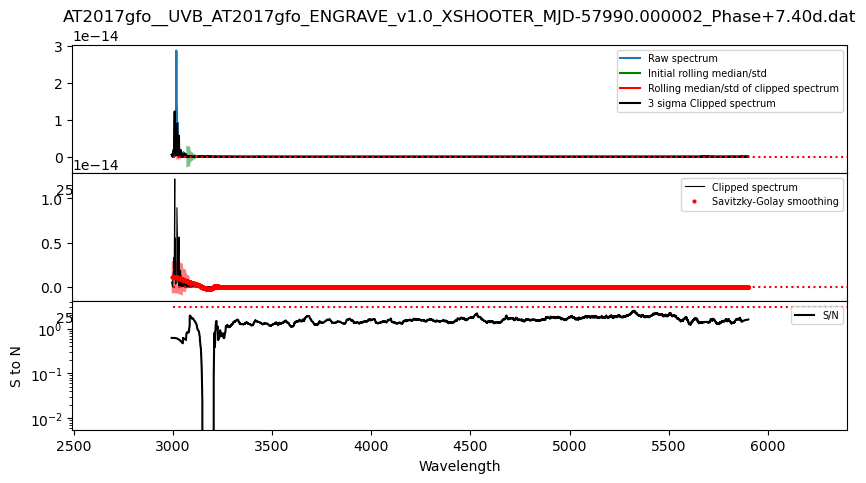

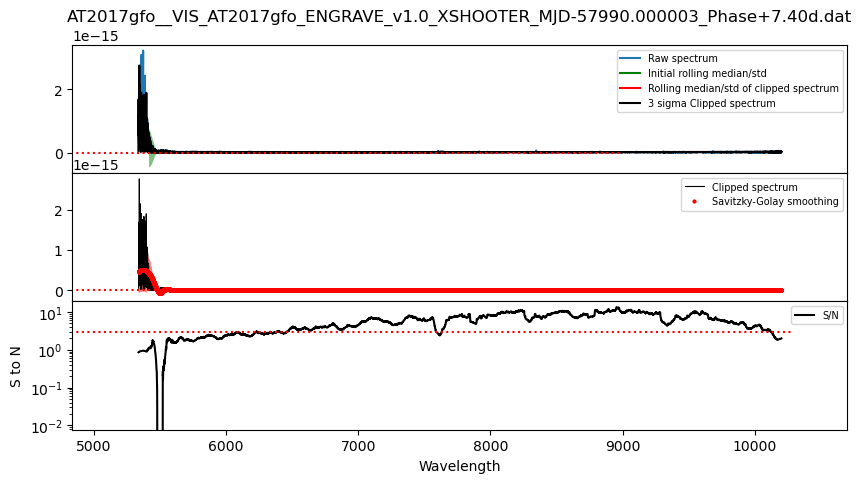

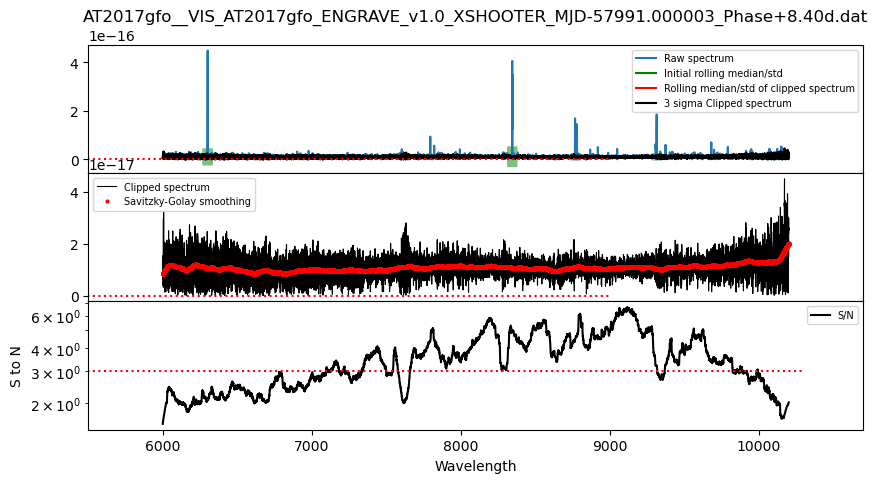

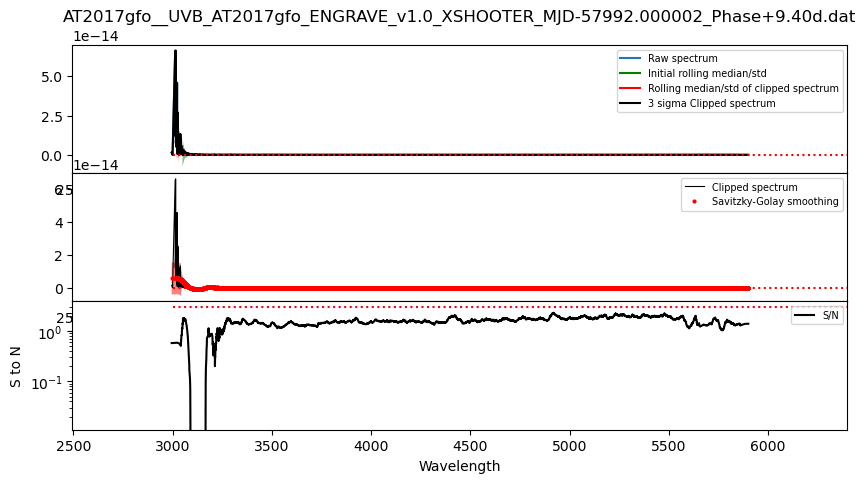

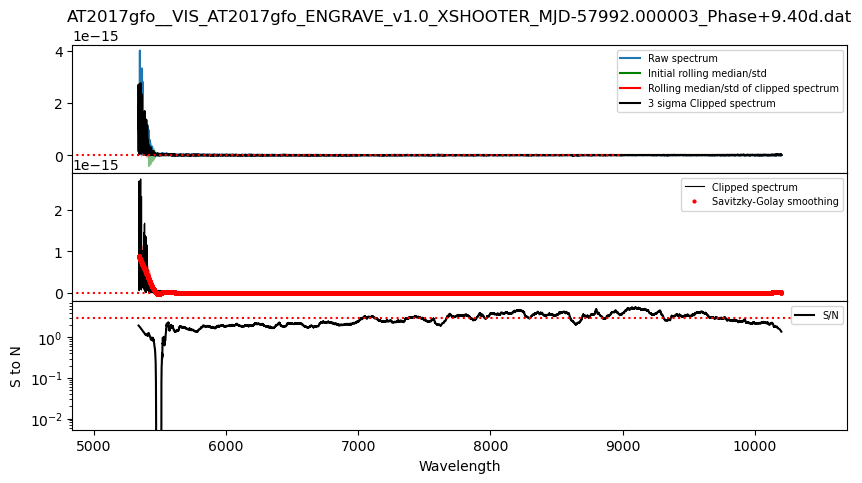

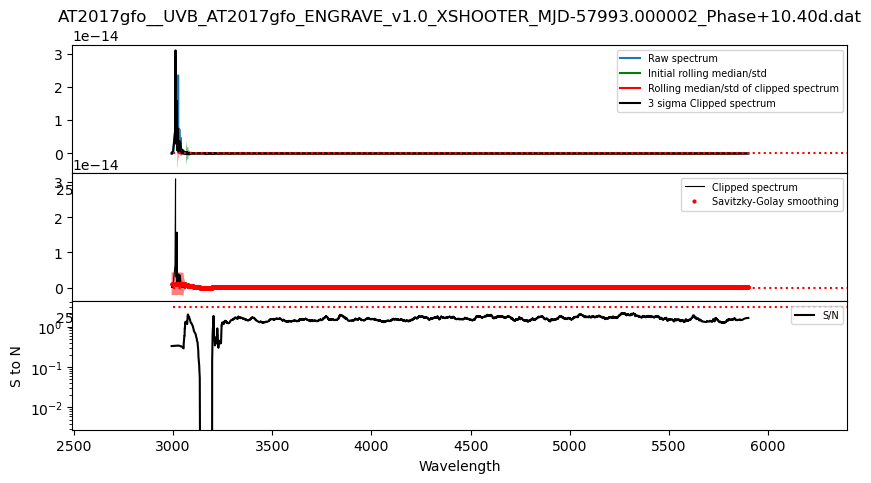

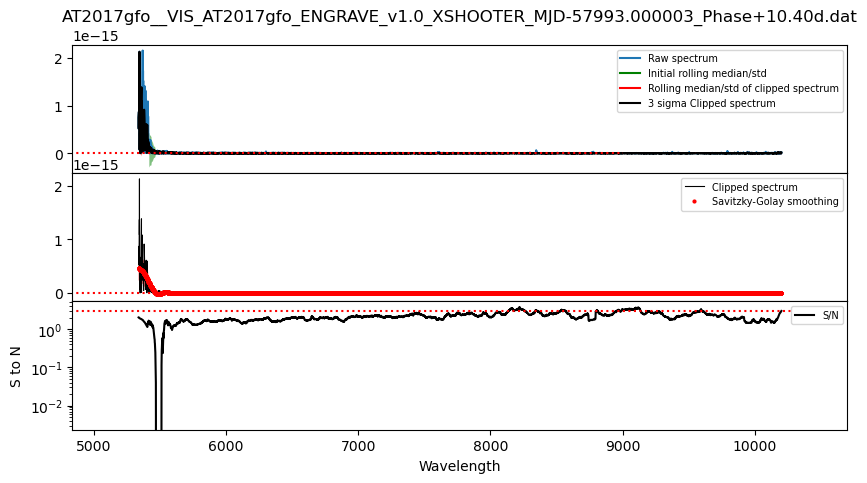

In [14]:
spec_class.smooth_all(200)